# SNODAS Wrapper

In [30]:
%matplotlib inline
import SNODAS
import re
import os
from datetime import datetime, timedelta
import xarray as xr

## Downloading Data from SNODAS
Data can be fetched from SNODAS using the `snodas_ds(date)` function. It can then be saved using the appropriate function e.g.`save_netcdf(dataset, path)` or `save_tiff(dataset, path)`

In [28]:
# Fetch data from SNODAS
start_date = datetime(2018,1,21)
for date in (start_date + timedelta(n) for n in range(1)):
    ds = SNODAS.snodas_ds(date)
    SNODAS.save_netcdf(ds, date.strftime('out/SNODAS_%Y%m%d.nc'))

## Loading Data in XArray
Data in NetCDF format can be loaded in XArray using `open_dataset` (for a single file) and `open_mfdataset` (for multiple files). It is important to assign time coordinates to the resulting array, in order to effectively query the data.

In [31]:
# Get list of valid files
pattern = re.compile("^SNODAS_\d{8}.nc$")
files = sorted([os.path.join("out",f) for f in os.listdir("out") if pattern.match(f)])

# Extract dates from files
dates = [SNODAS.dateFromFile(f) for f in files]

ds = xr.open_mfdataset(files, concat_dim='time').Band1
ds.coords['time'] = dates
ds = ds.where(ds != -9999)

## Selecting snow depth across region
Data can be selected in a particular region by using the `sel` and `isel` functions in conjunction with `slice`, as shown below.

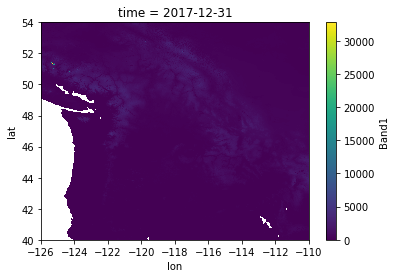

In [35]:
ds.sel(time = '2017-12-31', lat = slice(40, 54), lon = slice(-126, -110)).plot()

## Selecting time series at location
A time series can be constructed as follows. It is important that the method parameter is set to `'nearest'` in order to recieve results.

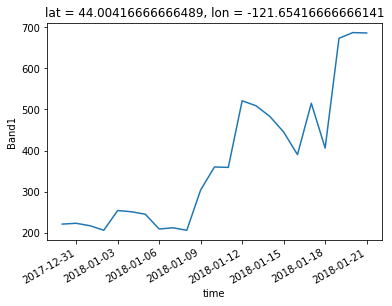

In [42]:
ds.sel(lon=-121.6555676, lat=44.0018751, method='nearest').plot()

## Selecting point data at time and location
Data can be easily selected for a particular location and date. In the example below, snow depth is retrieved for January 3, 2018 near 44° N, 121.65° W.

In [37]:
ds.sel(time = '2018-01-03', lon=-121.6555676, lat=44.0018751, method='nearest').load().item()

254.0